### Notebook for the statistical analysis of cell state abundance by condition.

- **Developed by**: Carlos Talavera-López Ph.D
- **Institute of Computational Biology - Computational Health Centre - Helmholtz Munich**
- v230202

### Load required modules

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats.distributions as dist
from statsmodels.stats.multicomp import pairwise_tukeyhsd

### Set up working environment

In [2]:
plt.show()

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.2
-----
PIL                 9.4.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
cffi                1.15.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
executing           1.2.0
h5py                3.8.0
igraph              0.10.4
importlib_resources NA
ipykernel           6.21.2
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.7.0
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.2.0
numba               0.56.4
numexpr             2.8.4
numpy               1.23.5
packaging           23.0
pandas              1.5.3
parso               0.8.3
patsy               0.5.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       N

### Read in data

In [3]:
sc_copd = sc.read_h5ad('../data/Marburg_All_ctl230404_leiden_states.raw.h5ad')
sc_copd

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout_by_coun

### Visualise cell-proportions per disease

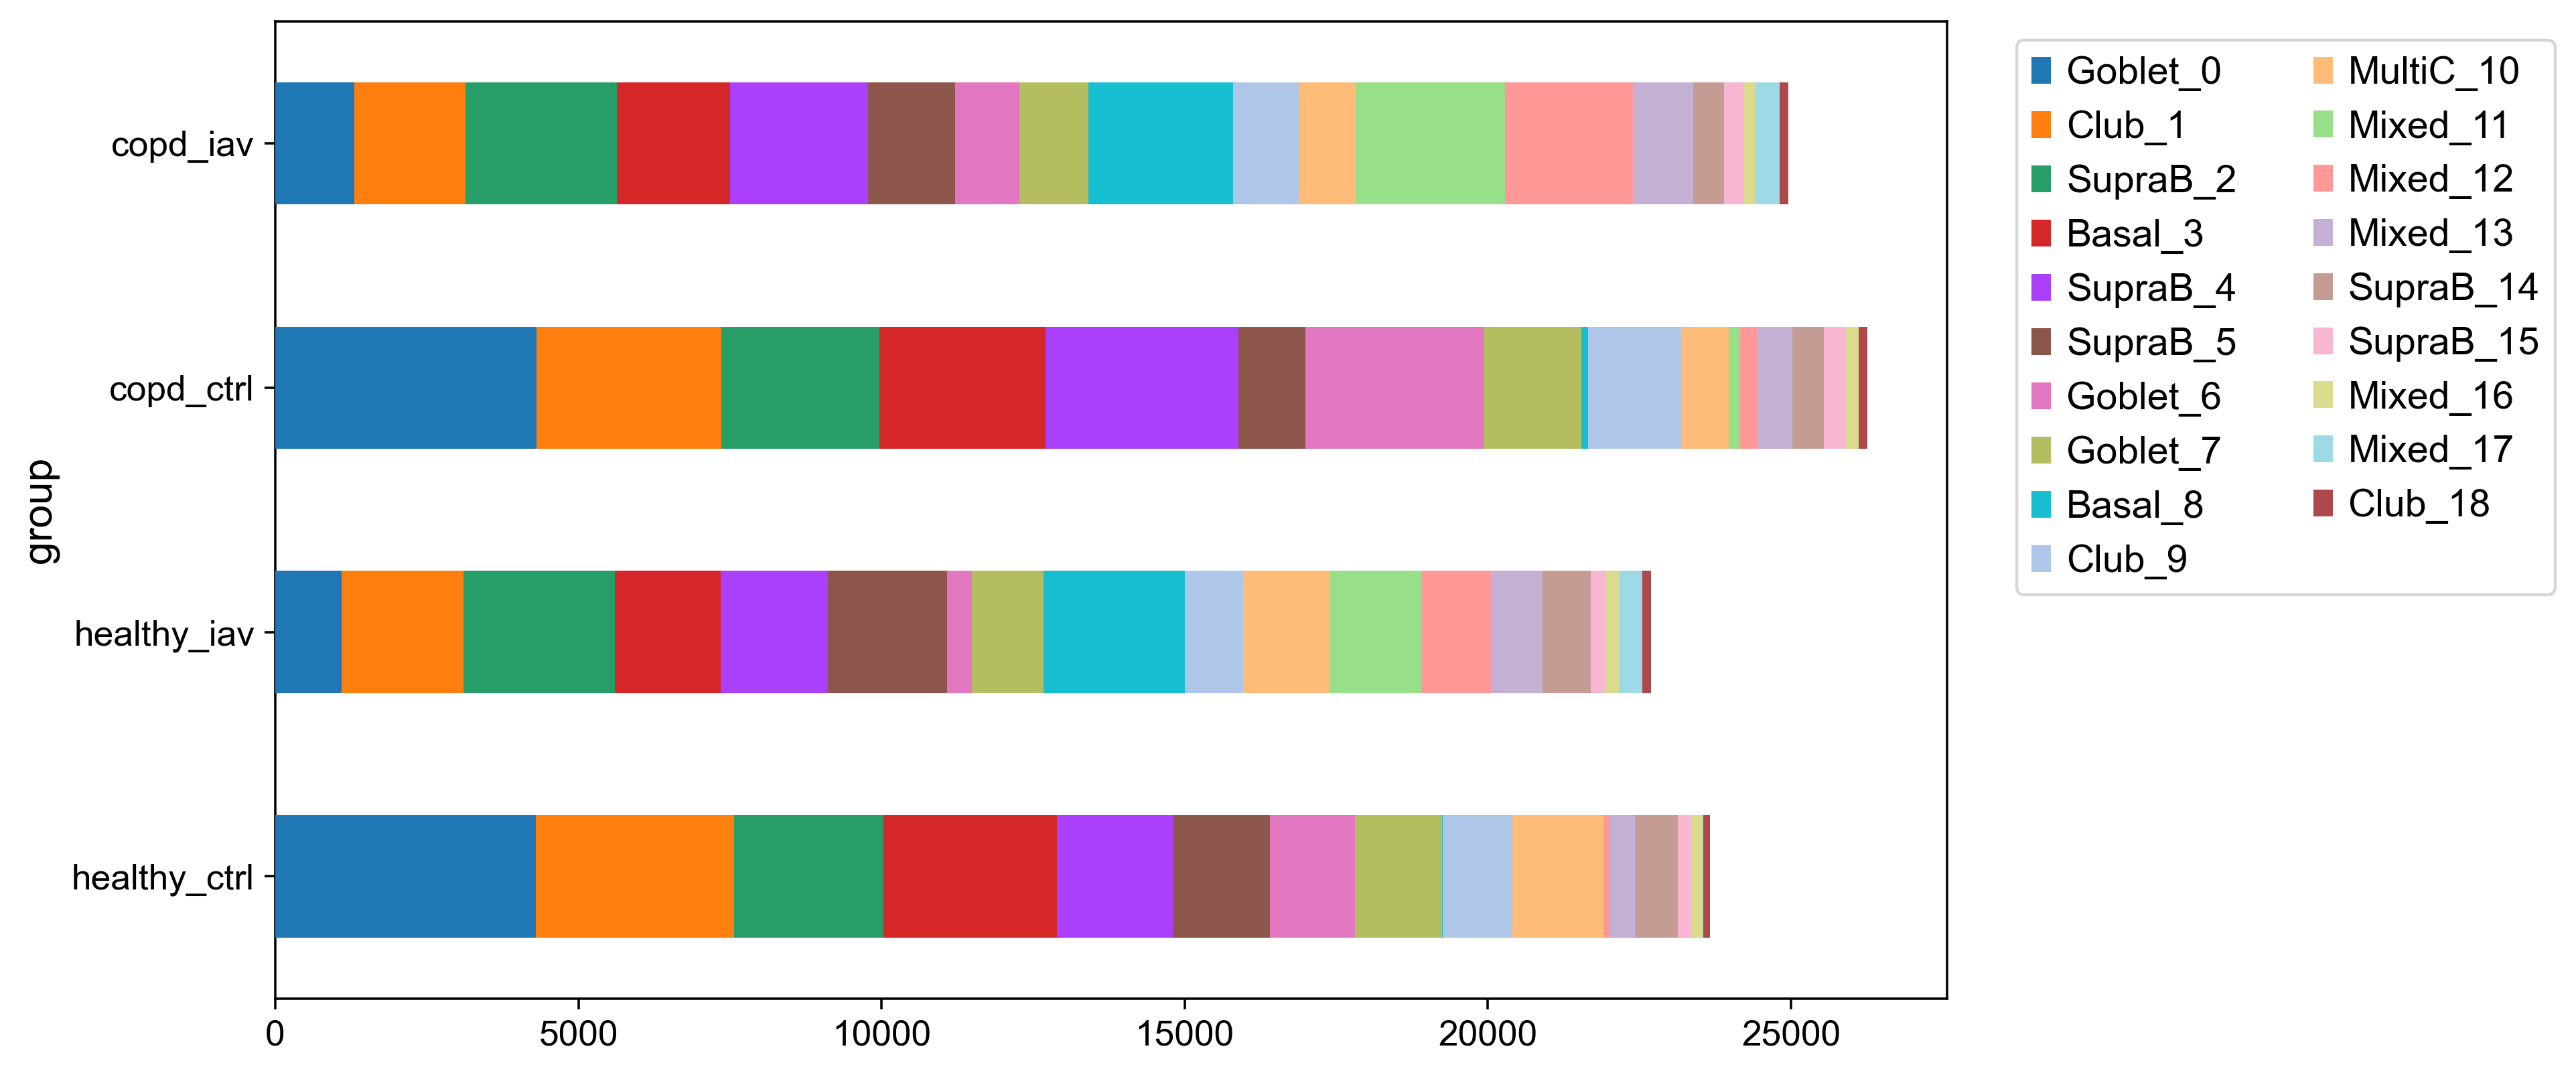

In [4]:
ax1 = pd.crosstab(sc_copd.obs['group'], sc_copd.obs['leiden_states']).plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (10,6), fontsize = 12, grid = False)
horiz_offset = 1.03
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 2)

### Create a contingency table for the tests

In [5]:
cell_proportions = pd.crosstab(sc_copd.obs['group'], sc_copd.obs['leiden_states'])
cell_proportions.head()

leiden_states,Goblet_0,Club_1,SupraB_2,Basal_3,SupraB_4,SupraB_5,Goblet_6,Goblet_7,Basal_8,Club_9,MultiC_10,Mixed_11,Mixed_12,Mixed_13,SupraB_14,SupraB_15,Mixed_16,Mixed_17,Club_18
group,,,,,,,,,,,,,,,,,,,
healthy_ctrl,4295,3268,2470,2856,1927,1584,1412,1437,6,1146,1493,21,99,411,706,231,181,5,119
healthy_iav,1096,2004,2499,1749,1765,1972,403,1179,2335,965,1429,1508,1146,856,786,264,206,388,137
copd_ctrl,4304,3058,2608,2734,3185,1099,2942,1611,114,1533,784,184,279,584,522,353,219,5,143
copd_iav,1308,1825,2503,1862,2282,1430,1066,1139,2377,1093,939,2457,2115,990,514,312,203,399,144


In [6]:
sc_copd.obs['leiden_states'].cat.categories

Index(['Goblet_0', 'Club_1', 'SupraB_2', 'Basal_3', 'SupraB_4', 'SupraB_5',
       'Goblet_6', 'Goblet_7', 'Basal_8', 'Club_9', 'MultiC_10', 'Mixed_11',
       'Mixed_12', 'Mixed_13', 'SupraB_14', 'SupraB_15', 'Mixed_16',
       'Mixed_17', 'Club_18'],
      dtype='object')

### Create groups for comparison

In [7]:
cell_proportions['Goblet_0'].tolist()

[4295, 1096, 4304, 1308]

In [13]:
Goblet_0 = cell_proportions['Goblet_0'].tolist()
Club_1 = cell_proportions['Club_1'].tolist()
SupraB_2 = cell_proportions['SupraB_2'].tolist()
Basal_3 = cell_proportions['Basal_3'].tolist()

SupraB_4 = cell_proportions['SupraB_4'].tolist()
SupraB_5 = cell_proportions['SupraB_5'].tolist()
Goblet_6 = cell_proportions['Goblet_6'].tolist()
Goblet_7 = cell_proportions['Goblet_7'].tolist()

Basal_8 = cell_proportions['Basal_8'].tolist()
Club_9 = cell_proportions['Club_9'].tolist()
MultiC_10 = cell_proportions['MultiC_10'].tolist()
Mixed_11 = cell_proportions['Mixed_11'].tolist()

Mixed_12 = cell_proportions['Mixed_12'].tolist()
Mixed_13 = cell_proportions['Mixed_13'].tolist()
SupraB_14 = cell_proportions['SupraB_14'].tolist()
SupraB_15 = cell_proportions['SupraB_15'].tolist()

Mixed_16 = cell_proportions['Mixed_16'].tolist()
Mixed_17 = cell_proportions['Mixed_17'].tolist()
Club_18 = cell_proportions['Club_18'].tolist()

### Perform One-Way ANOVA

In [14]:
stat, p = stats.f_oneway(Goblet_0, Club_1, SupraB_2, Basal_3, SupraB_4, SupraB_5, Goblet_6, Goblet_7, Basal_8, Club_9, MultiC_10, Mixed_11, Mixed_12, Mixed_13, SupraB_14, SupraB_15, Mixed_16, Mixed_17, Club_18)

print("Statistic: ", stat)
print("P-value: ", p)

if p < 0.05:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Statistic:  5.4527247288462535
P-value:  4.184272901079668e-07
Reject the null hypothesis.


### Perform post-hoc test

In [15]:
data = np.concatenate([Goblet_0, Club_1, SupraB_2, Basal_3, SupraB_4, SupraB_5, Goblet_6, Goblet_7, Basal_8, Club_9, MultiC_10, Mixed_11, Mixed_12, Mixed_13, SupraB_14, SupraB_15, Mixed_16, Mixed_17, Club_18])
groups = ['Goblet_0'] * len(Goblet_0) + ['Club_1'] * len(Club_1) + ['SupraB_2'] * len(SupraB_2) + ['Basal_3'] * len(Basal_3) + ['SupraB_4'] * len(SupraB_4) + ['SupraB_5'] * len(SupraB_5) + ['Goblet_6'] * len(Goblet_6) + ['Goblet_7'] * len(Goblet_7) + ['Basal_8'] * len(Basal_8) + ['Club_9'] * len(Club_9) + ['MultiC_10'] * len(MultiC_10) + ['Mixed_11'] * len(Mixed_11) + ['Mixed_12'] * len(Mixed_12) + ['Mixed_13'] * len(Mixed_13) + ['SupraB_14'] * len(SupraB_14) + ['SupraB_15'] * len(SupraB_15) + ['Mixed_16'] * len(Mixed_16) + ['Mixed_17'] * len(Mixed_17) + ['Club_18'] * len(Club_18)

In [16]:
df = pd.DataFrame({'data': data, 'groups': groups})

model = sm.OLS.from_formula('data ~ groups', df)
results = model.fit()

In [17]:
tukey = pairwise_tukeyhsd(df['data'], df['groups'])
print(tukey.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2  meandiff p-adj    lower      upper   reject
---------------------------------------------------------------
  Basal_3   Basal_8 -1092.25 0.8141 -2990.4542  805.9542  False
  Basal_3    Club_1    238.5    1.0 -1659.7042 2136.7042  False
  Basal_3   Club_18  -2164.5 0.0112 -4062.7042 -266.2958   True
  Basal_3    Club_9  -1116.0 0.7879 -3014.2042  782.2042  False
  Basal_3  Goblet_0    450.5    1.0 -1447.7042 2348.7042  False
  Basal_3  Goblet_6   -844.5  0.976 -2742.7042 1053.7042  False
  Basal_3  Goblet_7  -958.75 0.9267 -2856.9542  939.4542  False
  Basal_3  Mixed_11 -1257.75 0.6064 -3155.9542  640.4542  False
  Basal_3  Mixed_12  -1390.5 0.4269 -3288.7042  507.7042  False
  Basal_3  Mixed_13  -1590.0 0.2107 -3488.2042  308.2042  False
  Basal_3  Mixed_16  -2098.0 0.0166 -3996.2042 -199.7958   True
  Basal_3  Mixed_17  -2101.0 0.0163 -3999.2042 -202.7958   True
  Basal_3 MultiC_10  -1139.0 0.7611 -303

In [18]:
df = pd.DataFrame(data = tukey._results_table.data[1:], columns = tukey._results_table.data[0])
df

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Basal_3,Basal_8,-1092.25,0.8141,-2990.4542,805.9542,False
1,Basal_3,Club_1,238.50,1.0000,-1659.7042,2136.7042,False
2,Basal_3,Club_18,-2164.50,0.0112,-4062.7042,-266.2958,True
3,Basal_3,Club_9,-1116.00,0.7879,-3014.2042,782.2042,False
4,Basal_3,Goblet_0,450.50,1.0000,-1447.7042,2348.7042,False
...,...,...,...,...,...,...,...
166,SupraB_15,SupraB_4,1999.75,0.0289,101.5458,3897.9542,True
167,SupraB_15,SupraB_5,1231.25,0.6425,-666.9542,3129.4542,False
168,SupraB_2,SupraB_4,-230.25,1.0000,-2128.4542,1667.9542,False
169,SupraB_2,SupraB_5,-998.75,0.8994,-2896.9542,899.4542,False


In [19]:
df.to_csv('230607_scCOPD_ANOVA_cell_proportions_Tukey.tsv', sep = ',', index = False)

### Visualise significant proportions

- Subset to significant populations

In [20]:
sc_copd.obs['leiden_states'].cat.categories

Index(['Goblet_0', 'Club_1', 'SupraB_2', 'Basal_3', 'SupraB_4', 'SupraB_5',
       'Goblet_6', 'Goblet_7', 'Basal_8', 'Club_9', 'MultiC_10', 'Mixed_11',
       'Mixed_12', 'Mixed_13', 'SupraB_14', 'SupraB_15', 'Mixed_16',
       'Mixed_17', 'Club_18'],
      dtype='object')

In [26]:
sc_copd_sig = sc_copd[sc_copd.obs['leiden_states'].isin(['Basal_3', 'Club_1', 'Club_18', 'Goblet_0' , 'Mixed_16', 'Mixed_17', 'SupraB_15', 'SupraB_14', 'SupraB_2', 'Mixed_13', 'SupraB_4'])]
sc_copd_sig

View of AnnData object with n_obs × n_vars = 58276 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', '_scvi_batch', '_scvi_labels', 'IAV_score', 'group', 'C_scANVI', 'cell_type', 'leiden', 'leiden_states'
    var: 'mt', 'ribo', 'n_cells_by_counts-V1', 'mean_counts-V1', 'pct_dropout_by_counts-V1', 'total_counts-V1', 'n_cells_by_counts-V2', 'mean_counts-V2', 'pct_dropout_by_counts-V2', 'total_counts-V2', 'n_cells_by_counts-V3', 'mean_counts-V3', 'pct_dropout_by_counts-V3', 'total_counts-V3', 'n_cells_by_counts-V4', 'mean_counts-V4', 'pct_dropout_by_counts-V4', 'total_counts-V4', 'n_cells_by_counts-V5', 'mean_counts-V5', 'pct_dropout

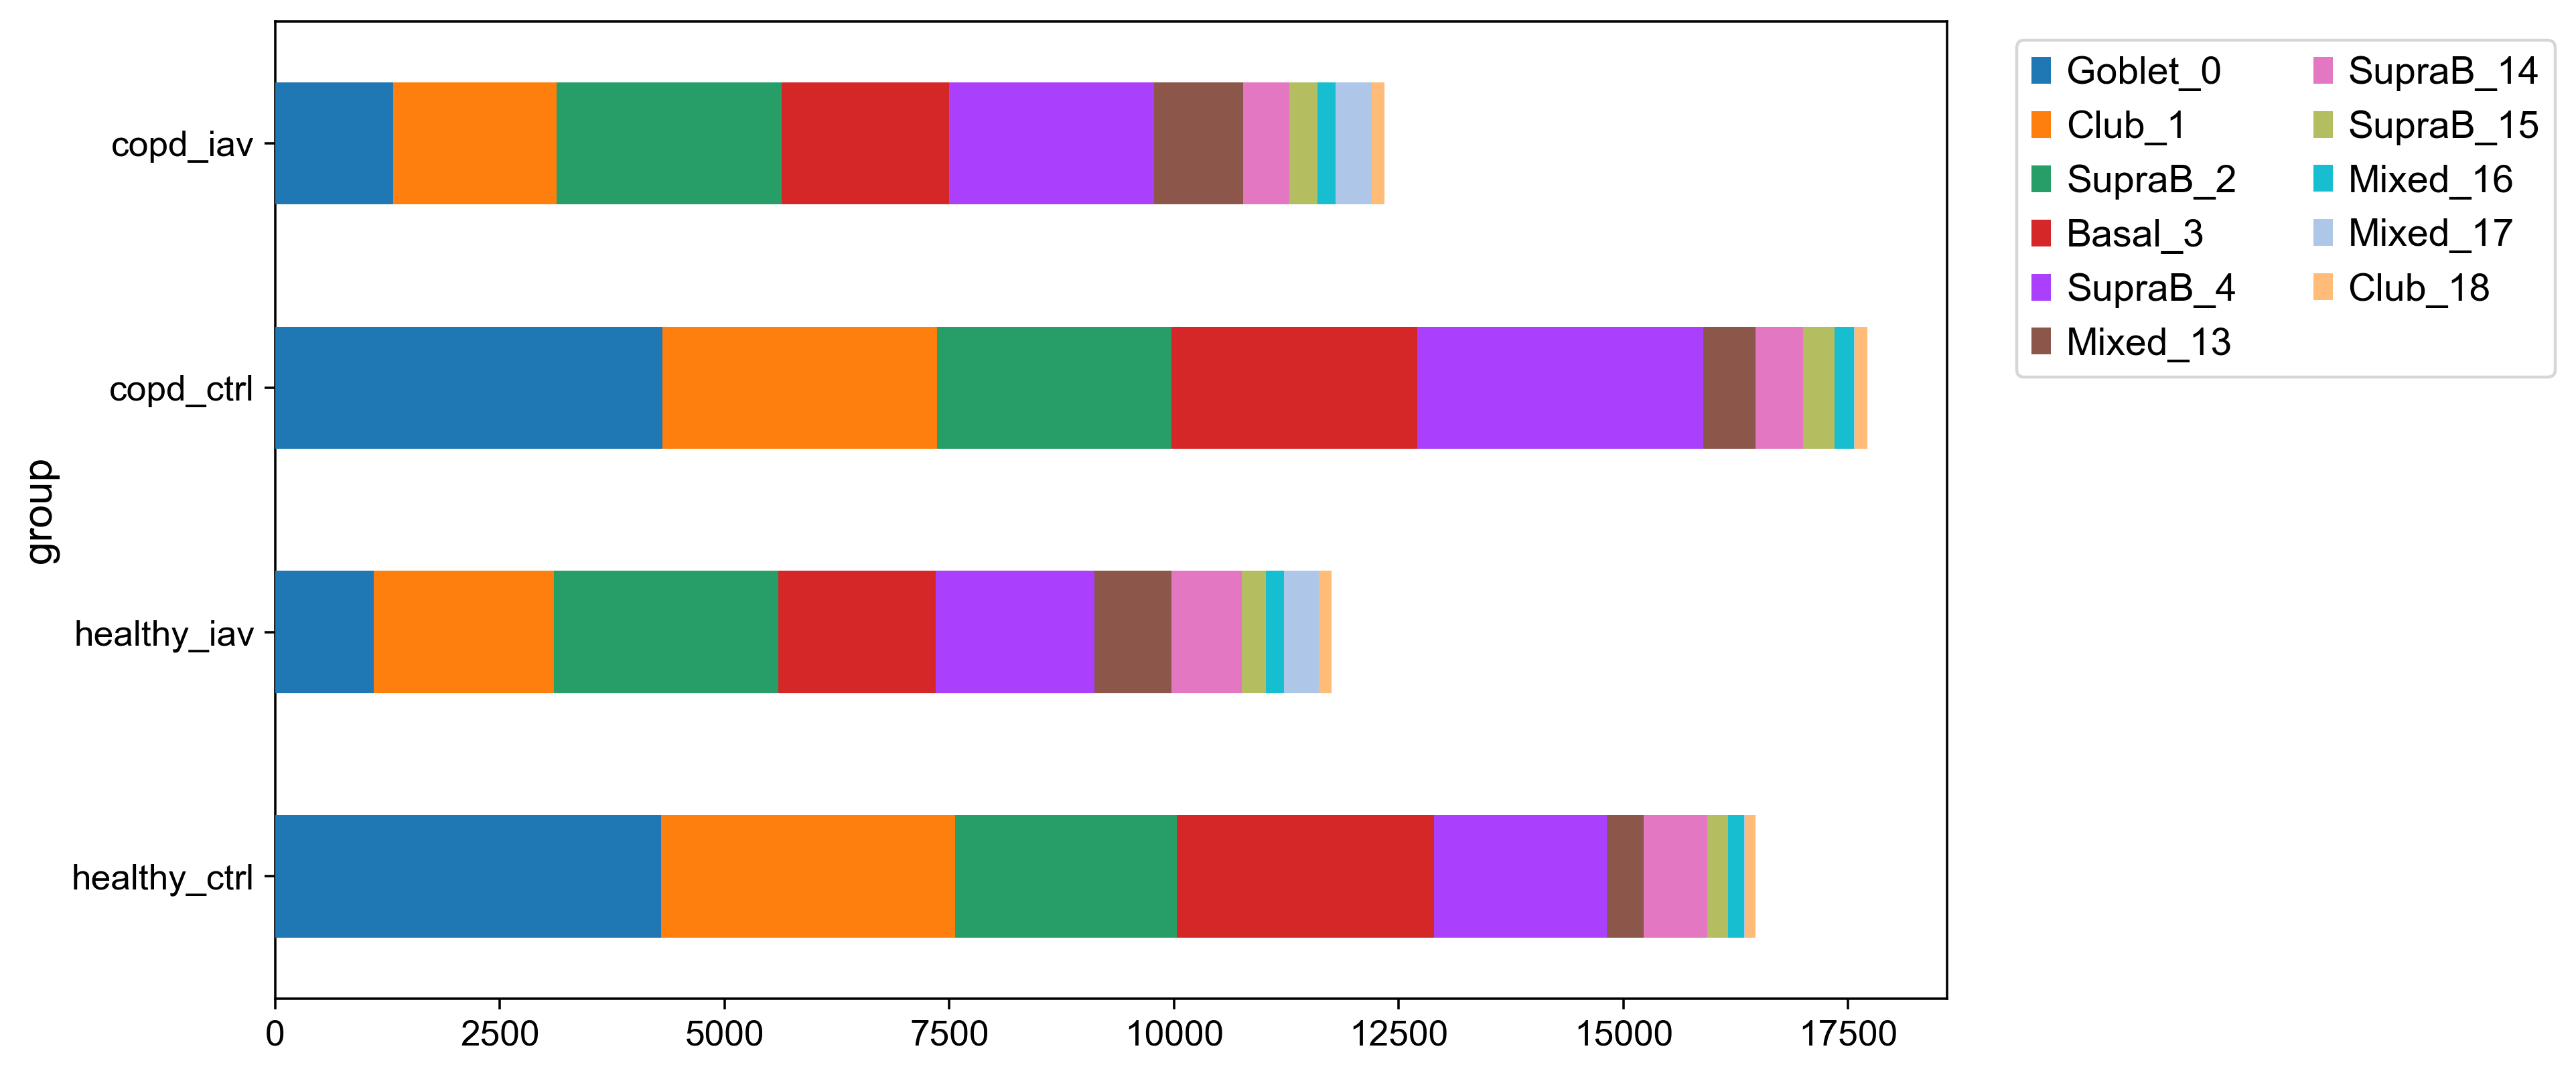

In [27]:
ax1 = pd.crosstab(sc_copd_sig.obs['group'], sc_copd_sig.obs['leiden_states']).plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (10,6), fontsize = 12, grid = False)
horiz_offset = 1.03
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 2)

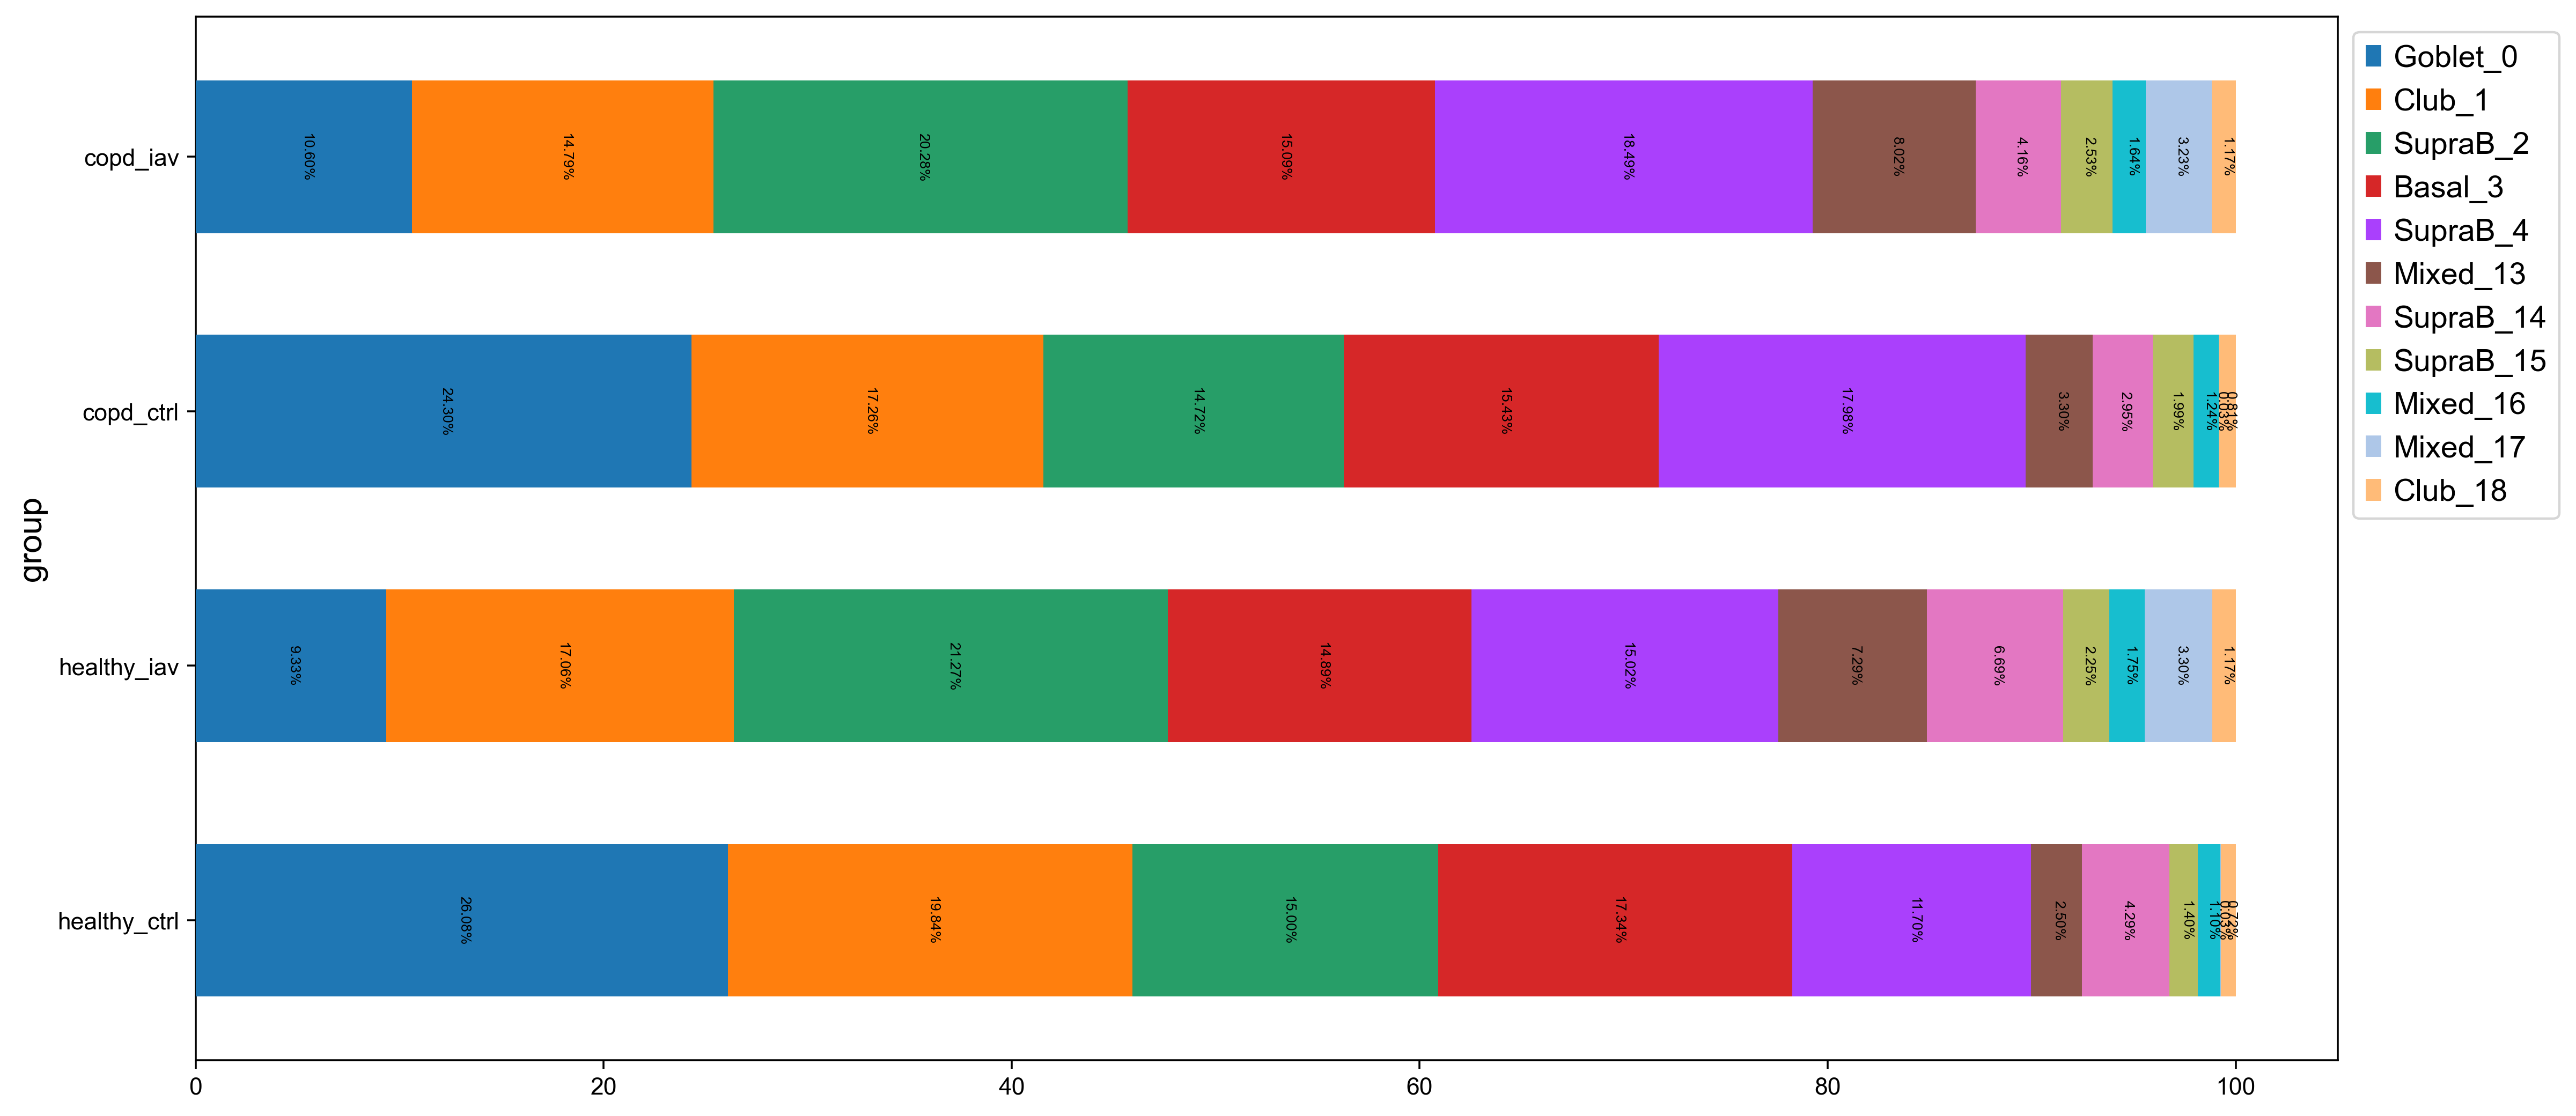

In [28]:
data = pd.crosstab(sc_copd_sig.obs['group'], sc_copd_sig.obs['leiden_states'])
totals = data.sum(axis = 1)
percent = data.div(totals, axis = 0).mul(100).round(2)

ax1 = percent.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (16,8), fontsize = 10, grid = False, width = 0.6)
horiz_offset = 1.0
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 1)

for c in ax1.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{w:0.2f}%' if (w := v.get_width()) > 0 else '' for v in c]
    
    # add annotations
    ax1.bar_label(c, labels = labels, label_type = 'center', padding = 1, color = 'black', rotation = 270, fontsize = 6)

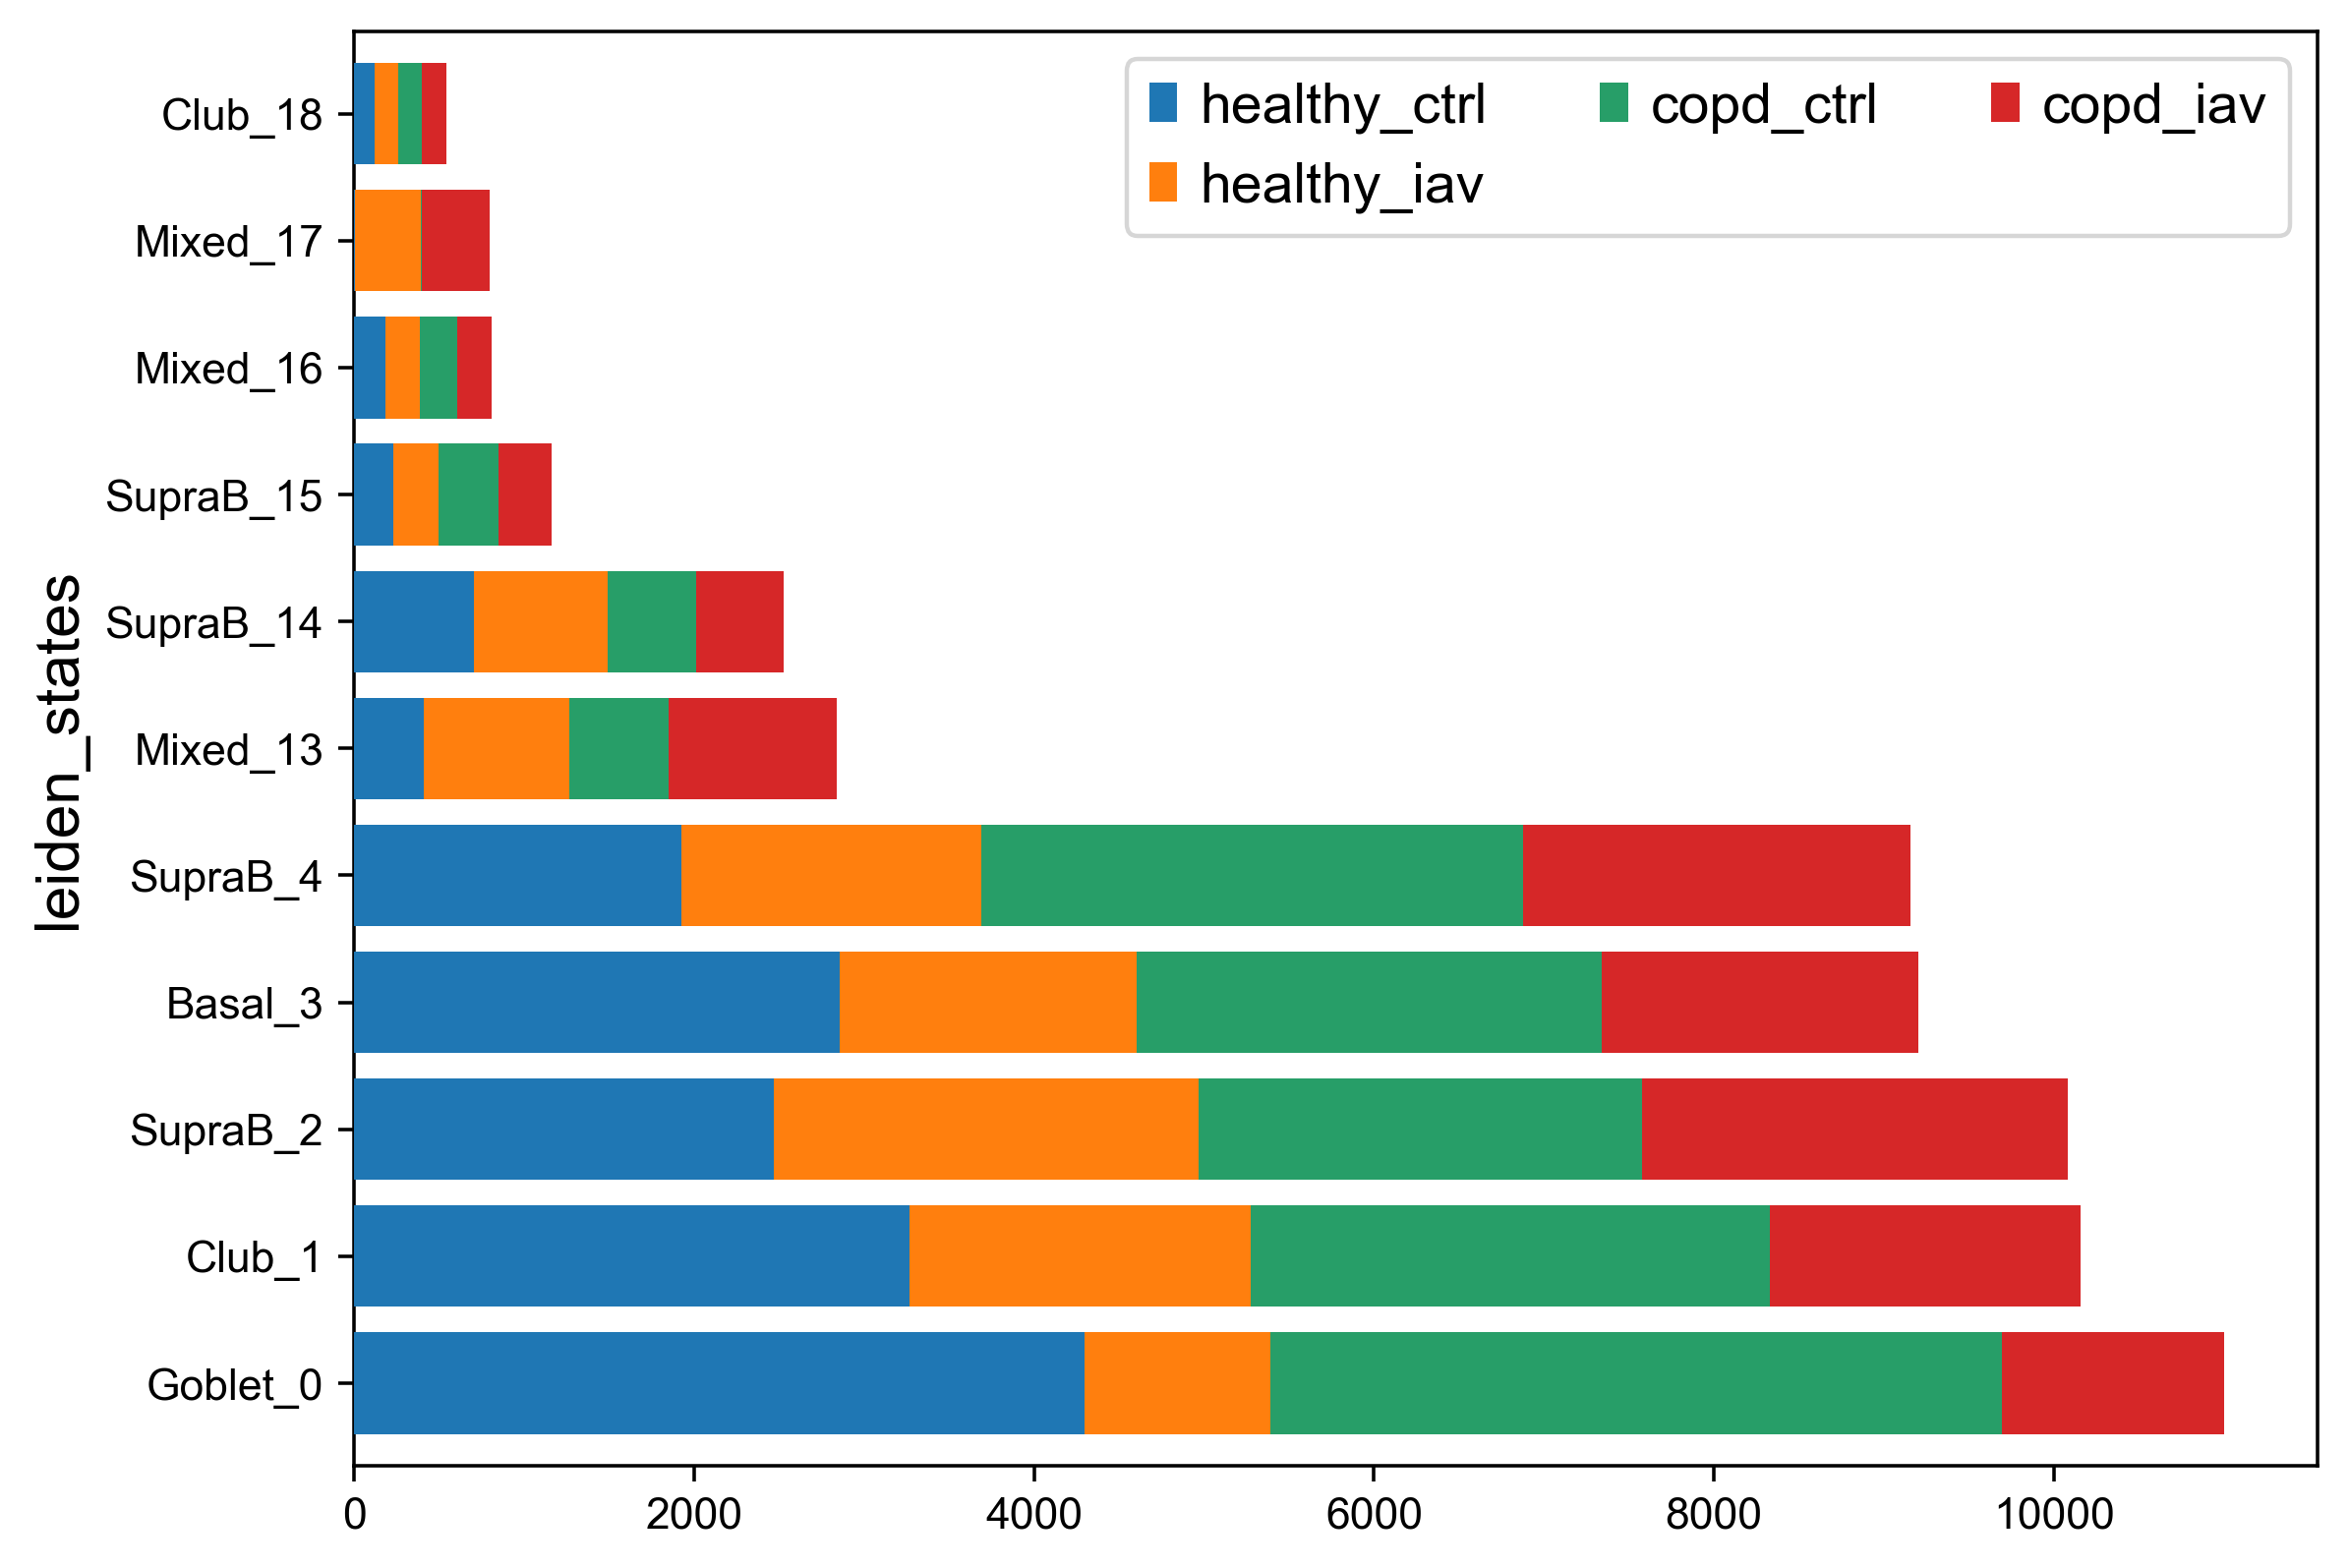

In [29]:
ax1 = pd.crosstab(sc_copd_sig.obs['leiden_states'], sc_copd_sig.obs['group']).plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (8,6), fontsize = 10, grid = False, width = 0.8)
horiz_offset = 1.0
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 3)

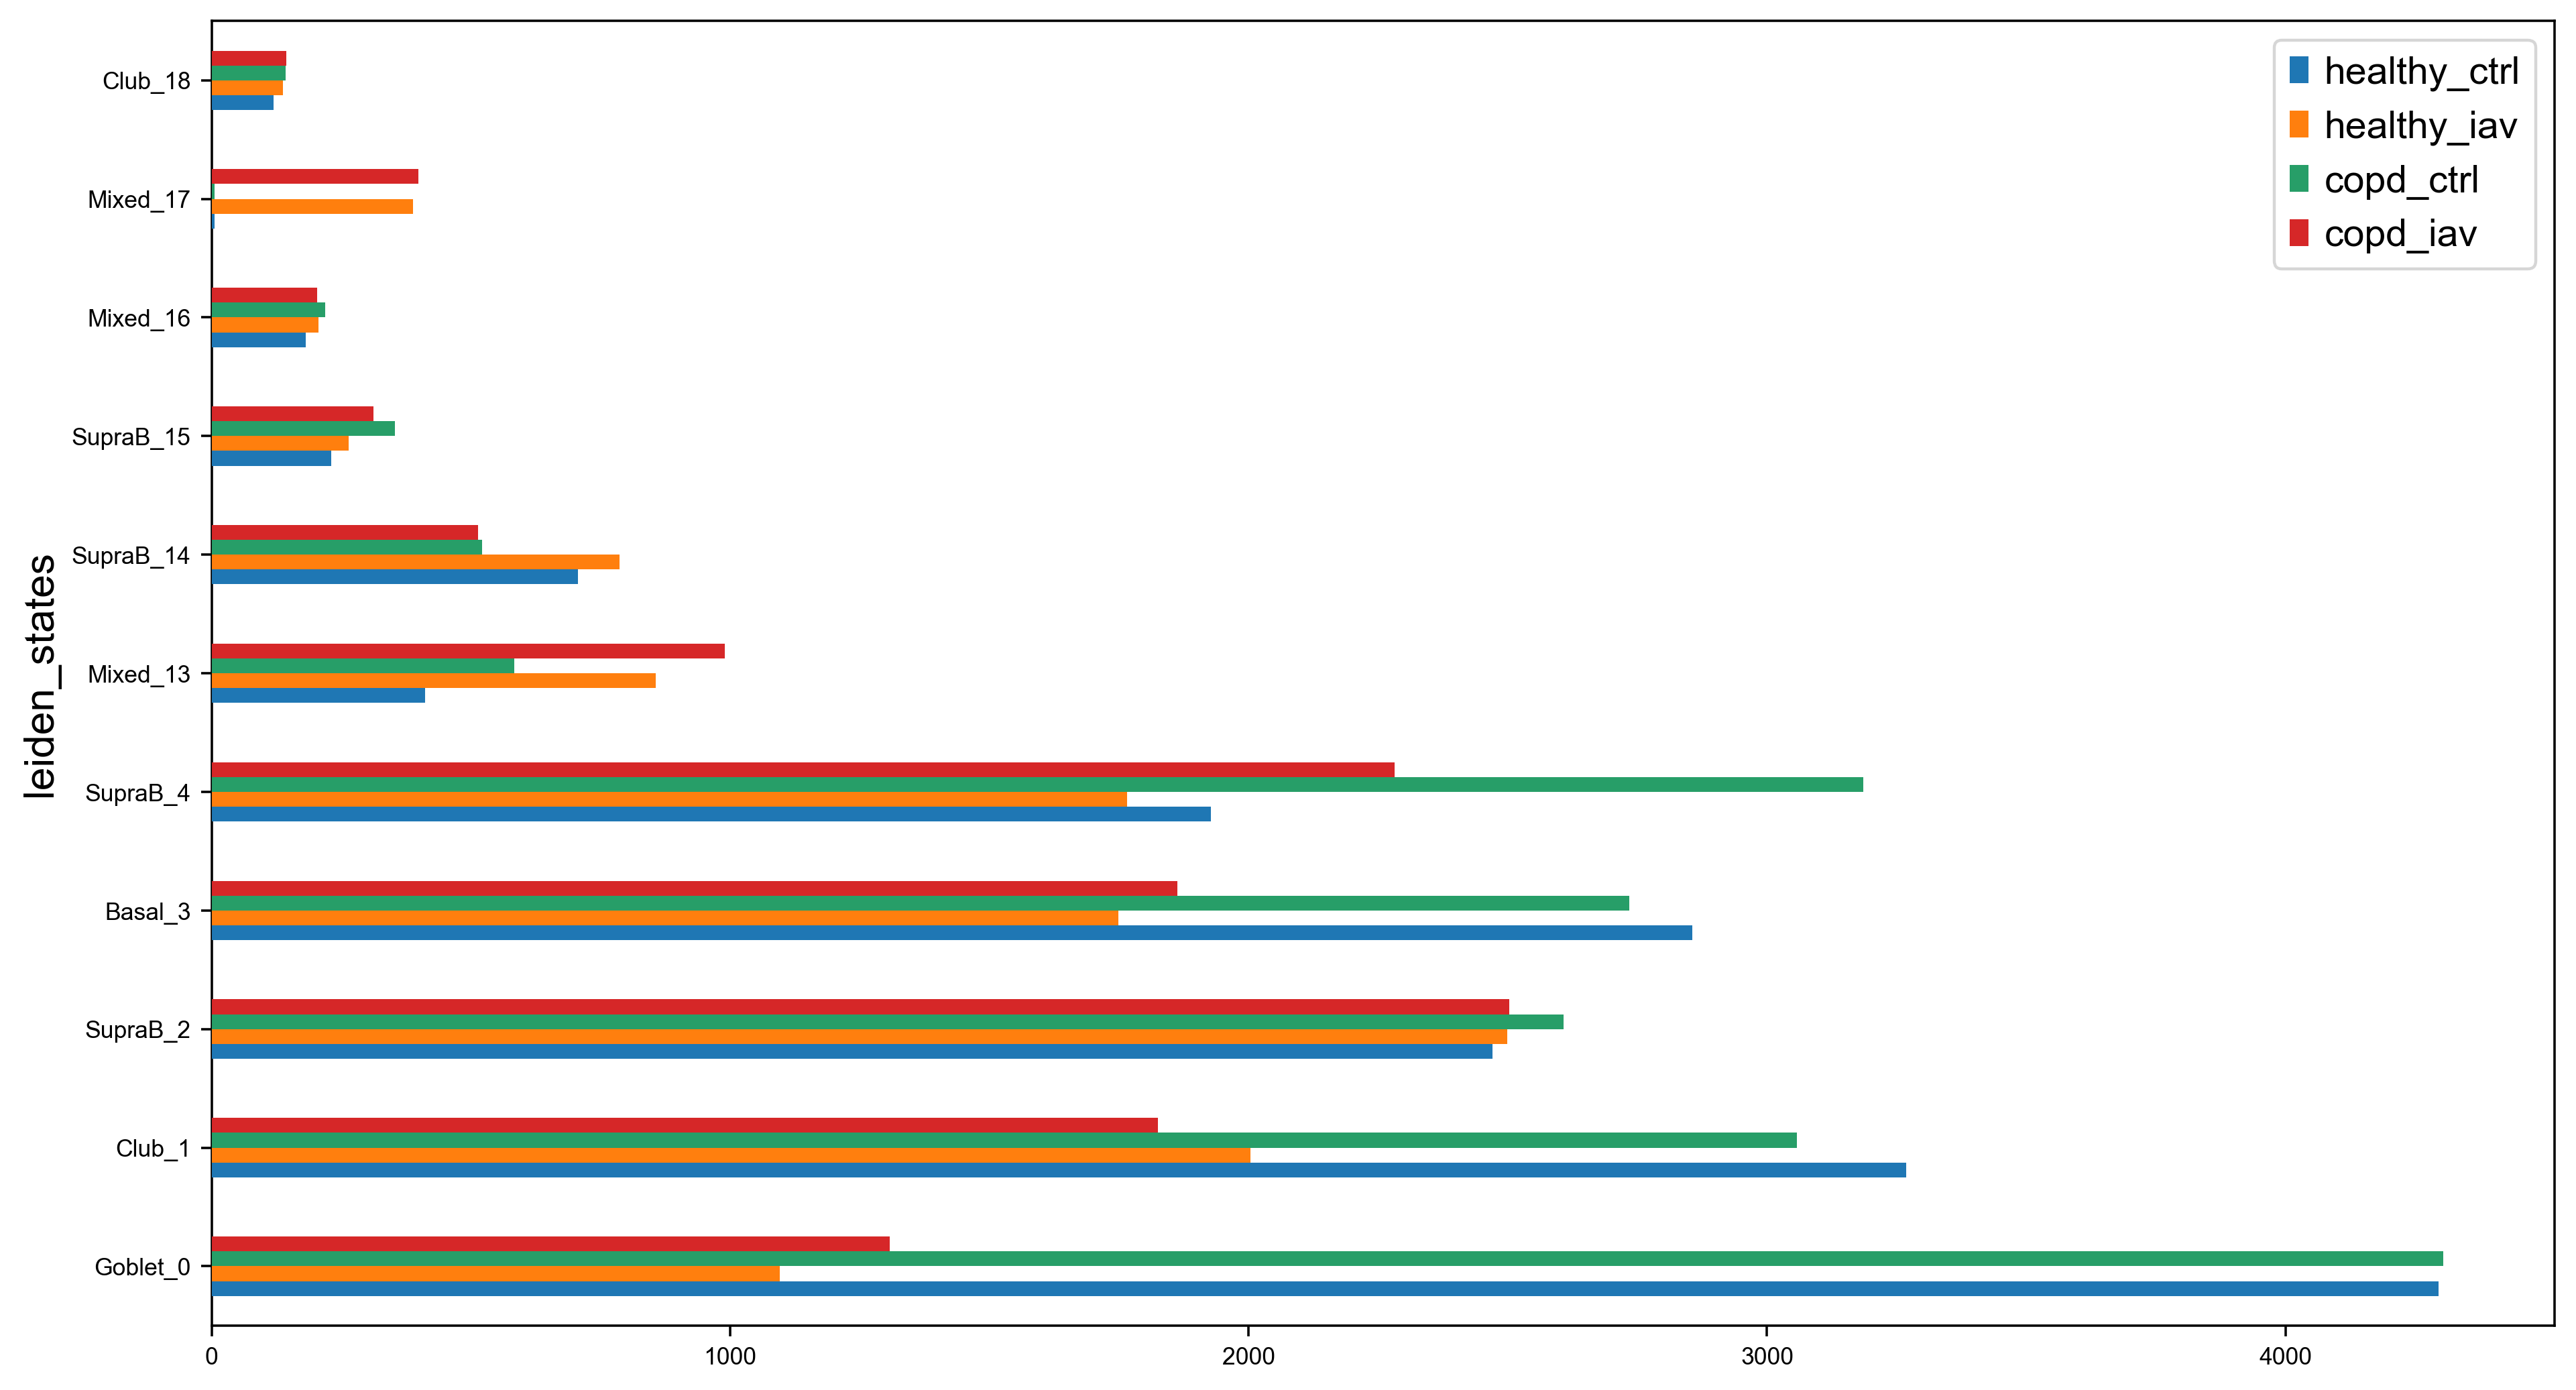

In [30]:
ax1 = pd.crosstab(sc_copd_sig.obs['leiden_states'], sc_copd_sig.obs['group']).plot.barh(stacked = False, edgecolor = 'none', zorder = 3, figsize = (14,8), fontsize = 8, grid = False, width = 0.5)
horiz_offset = 1.0
vert_offset = 1.0
ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset), ncol = 1)

### Comparison of cell types between conditions

In [ ]:
t_stat, p_value = ttest_ind(BasalR_3, sample2)
print("T-statistic value: ", t_stat)  
print("P-Value: ", p_value)